In [84]:
%matplotlib inline
import pandas as pd
import numpy as np
import re
from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt
from requests import get
from bs4 import BeautifulSoup
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

**Dataframe Preparation**

In [85]:
food = pd.read_pickle("food.pkl")
restaurants = pd.read_pickle("restaurants.pkl")

In [86]:
food.head()

,Inspection ID,AKA Name,License #,Facility Type,Risk,Inspection Date,Inspection Type,Results,Violations,Latitude,Longitude
0,2320830,"THE HOXTON, CHICAGO",2694640.0,Restaurant,Risk 2 (Medium),2019,License,Pass,36. THERMOMETERS PROVIDED & ACCURATE - Comment...,41.885699,-87.648789
1,2320831,OGDEN PLAZA INC.,2475982.0,Grocery Store,Risk 3 (Low),2019,Canvass,Out of Business,NaN,41.855266,-87.712402
2,2320795,THE EXCHANGE,2698572.0,Restaurant,Risk 1 (High),2019,License,Pass,NaN,41.887529,-87.632647
3,2320768,The Manor,22971.0,Restaurant,Risk 1 (High),2019,Canvass,No Entry,NaN,41.807924,-87.728164
4,2320719,"4884 S ARCHER INC,.",2678088.0,Grocery Store,Risk 3 (Low),2019,License,Fail,NaN,41.804621,-87.719907


In [87]:
restaurants["Facility Type"].unique().tolist()

['Restaurant']

**Risk analysis:**

1) Pourcentage de 1, 2 et 3 sur chaque année

2) Différences niveaux pour même chaîne (lié à la position?)

3) Notes des chaînes/écoles

4) Distributions des notes par année

**1. Percentage distribution of risk level throughout the years** 

In [88]:
#risk distribution for every year
year_list = food["Inspection Date"].unique().tolist()
year_list.sort()
all_risks =  [[0 for _ in range(3)] for _ in range(len(year_list))]
year = 0
for i in year_list:
    all_risks[year] = food[food["Inspection Date"]==i].Risk.value_counts().sort_index().tail(3).tolist()
    year += 1

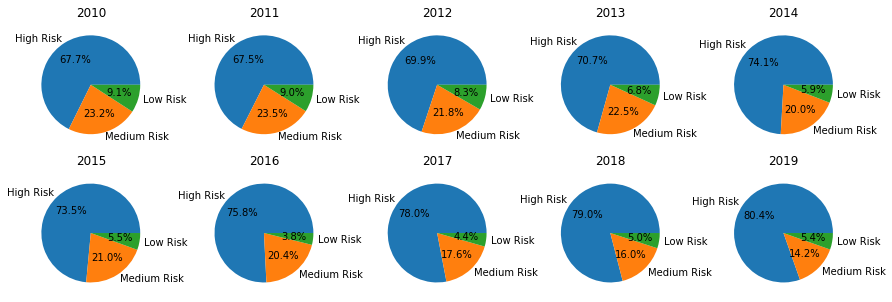

In [89]:
#plotting
labels = ['High Risk', 'Medium Risk', 'Low Risk']
fig, ax= plt.subplots(2,int(len(year_list)/2),figsize=(15,5))

year = 0
for i in range(2):
    for j in range(int(len(year_list)/2)):
        ax[i,j].pie(all_risks[year], labels = labels, autopct='%1.1f%%')
        ax[i,j].set_title(year_list[year])
        year += 1

plt.show()

**Discussion**

We see that the distribution of different risk levels has slowly changed since 2010. There is a slow increase in high risk aka fast foods 

**Risk analysis per restaurant for 2018**

In [90]:
new_restaurants = restaurants[restaurants["Inspection Date"]=='2018'].copy()
new_restaurants.reset_index(drop=True, inplace=True)

In [91]:
new_restaurants.head(10)

,Inspection ID,AKA Name,License #,Facility Type,Risk,Inspection Date,Inspection Type,Results,Violations,Latitude,Longitude
0,2243942,DUNKIN DONUTS,2536449.0,Restaurant,Risk 2 (Medium),2018,Canvass,Pass w/ Conditions,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.896458,-87.636098
1,2243941,DUNKIN DONUTS,23610.0,Restaurant,Risk 2 (Medium),2018,Canvass,Pass,49. NON-FOOD/FOOD CONTACT SURFACES CLEAN - Com...,41.995853,-87.670347
2,2243922,SUBWAY,1947909.0,Restaurant,Risk 1 (High),2018,Canvass,Pass w/ Conditions,5. PROCEDURES FOR RESPONDING TO VOMITING AND D...,41.775287,-87.722819
3,2243903,SUBWAY,1980425.0,Restaurant,Risk 1 (High),2018,Canvass,Pass w/ Conditions,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.945599,-87.766599
4,2243876,SUBWAY,2221641.0,Restaurant,Risk 1 (High),2018,Canvass Re-Inspection,Pass,10. ADEQUATE HANDWASHING SINKS PROPERLY SUPPLI...,41.778859,-87.703405
5,2243885,MCDONALDS,2637057.0,Restaurant,Risk 2 (Medium),2018,License,Pass,10. ADEQUATE HANDWASHING SINKS PROPERLY SUPPLI...,41.808359,-87.696001
6,2243872,SUBWAY,1904894.0,Restaurant,Risk 1 (High),2018,Canvass,Out of Business,NaN,41.865676,-87.625944
7,2243828,SUBWAY,2374636.0,Restaurant,Risk 1 (High),2018,Canvass,Pass w/ Conditions,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.873925,-87.630803
8,2243844,STARBUCKS,1515016.0,Restaurant,Risk 2 (Medium),2018,Canvass,Pass,51. PLUMBING INSTALLED; PROPER BACKFLOW DEVICE...,41.867571,-87.630586
9,2243835,DUNKIN DONUTS,1986419.0,Restaurant,Risk 2 (Medium),2018,Canvass,Pass w/ Conditions,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.873997,-87.630806
